In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import ipywidgets as widgets

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print train.columns
print test.columns

Index([u'Dates', u'Category', u'Descript', u'DayOfWeek', u'PdDistrict',
       u'Resolution', u'Address', u'X', u'Y'],
      dtype='object')
Index([u'Id', u'Dates', u'DayOfWeek', u'PdDistrict', u'Address', u'X', u'Y'], dtype='object')


The test data lacks the Category (obviously), Descript, and Resolution columns, so we probably shouldn't use those in training our model.

In [4]:
print len(train), '\n', train.count()
print len(test), '\n', test.count()

878049 
Dates         878049
Category      878049
Descript      878049
DayOfWeek     878049
PdDistrict    878049
Resolution    878049
Address       878049
X             878049
Y             878049
dtype: int64
884262 
Id            884262
Dates         884262
DayOfWeek     884262
PdDistrict    884262
Address       884262
X             884262
Y             884262
dtype: int64


There are no null values in both the train and test data!  This simplifies things for us quite a bit.

In [5]:
print train.X.describe()
print train.Y.describe()
print
print len(train[train.X == train.X.max()])
print len(train[train.Y == train.Y.max()])
print
print len(test[test.X == test.X.max()])
print len(test[test.Y == test.Y.max()])

count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64

67
67

76
76


However, there appear to 67 rows in the train data and 76 rows in the test data with erroneous X and Y values.  My guess is that an X value of -120.5 and a Y value of 90.0 indicate that the actual latitude and longitude are not known for that row.  Each row _does_ have the PdDistrict information, so it should be possible to give a decent guess for these rows using an average of some kind from the other rows in that PdDistrict.

In [6]:
def compare_counts(series1, series2):
    s1 = series1.value_counts().sort_index()
    s2 = series2.value_counts().sort_index()

    max_len = s1.index.map(len).max()
    for i in range(len(s1)):
        print '{: <{fill}}\t{}\t{}'.format(s1.index[i], s1[i], s2[i], fill=max_len)       

compare_counts(train.PdDistrict, test.PdDistrict)
print
compare_counts(train.DayOfWeek, test.DayOfWeek)

BAYVIEW   	89431	89591
CENTRAL   	85460	86130
INGLESIDE 	78845	80084
MISSION   	119908	120449
NORTHERN  	105296	107017
PARK      	49313	50199
RICHMOND  	45209	44972
SOUTHERN  	157182	157456
TARAVAL   	65596	66617
TENDERLOIN	81809	81747

Friday   	133734	134703
Monday   	121584	122226
Saturday 	126810	127038
Sunday   	116707	116415
Thursday 	125038	126541
Tuesday  	124965	126940
Wednesday	129211	130399


It looks like the train data is pretty representative of the test data, at least in the district and day of week breakdowns.  Let's visualize this!

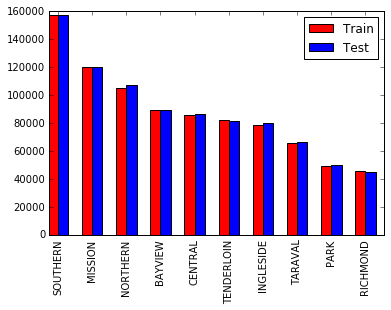

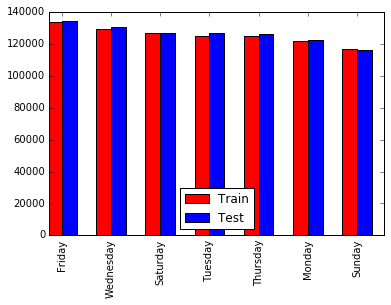

In [7]:
train.PdDistrict.value_counts().plot(kind='bar', position=1, color='r', width=0.3, align='center')
test.PdDistrict.value_counts().plot(kind='bar', position=0, color='b', width=0.3, align='center')
plt.legend(['Train', 'Test'])

plt.figure()
train.DayOfWeek.value_counts().plot(kind='bar', position=1, color='r', width=0.3, align='center')
test.DayOfWeek.value_counts().plot(kind='bar', position=0, color='b', width=0.3, align='center')
plt.legend(['Train', 'Test'], loc='best')

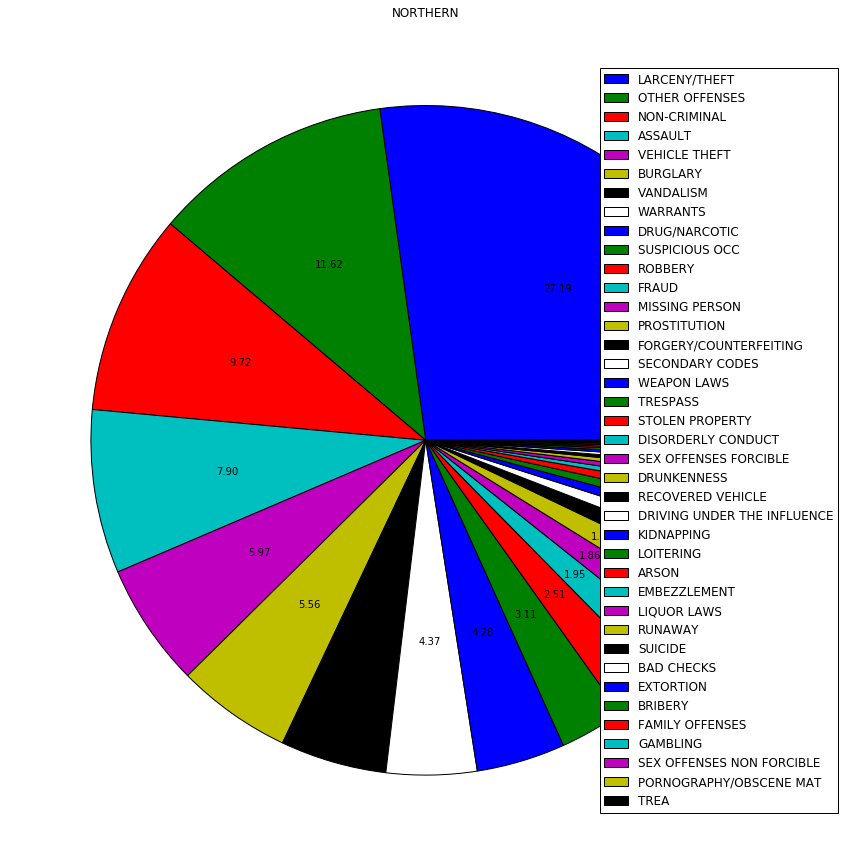

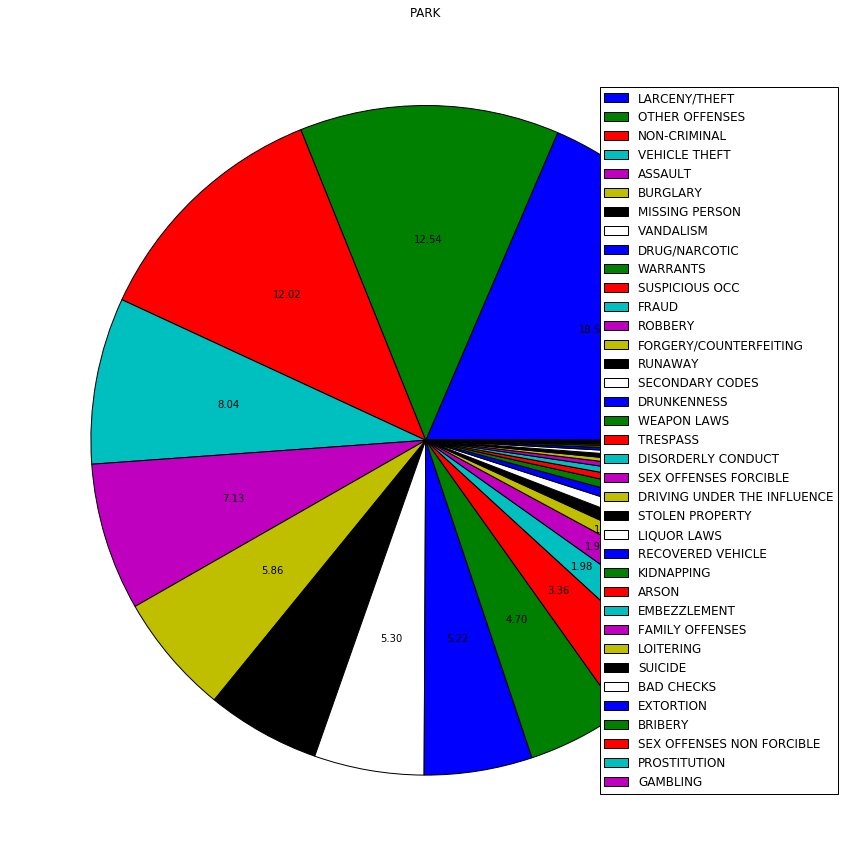

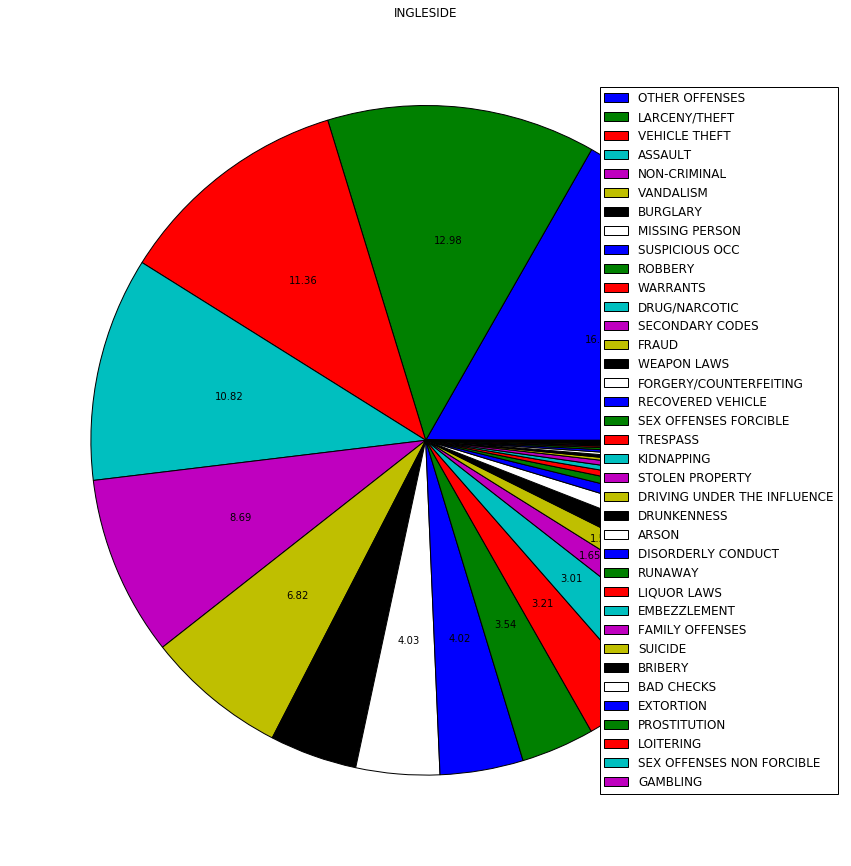

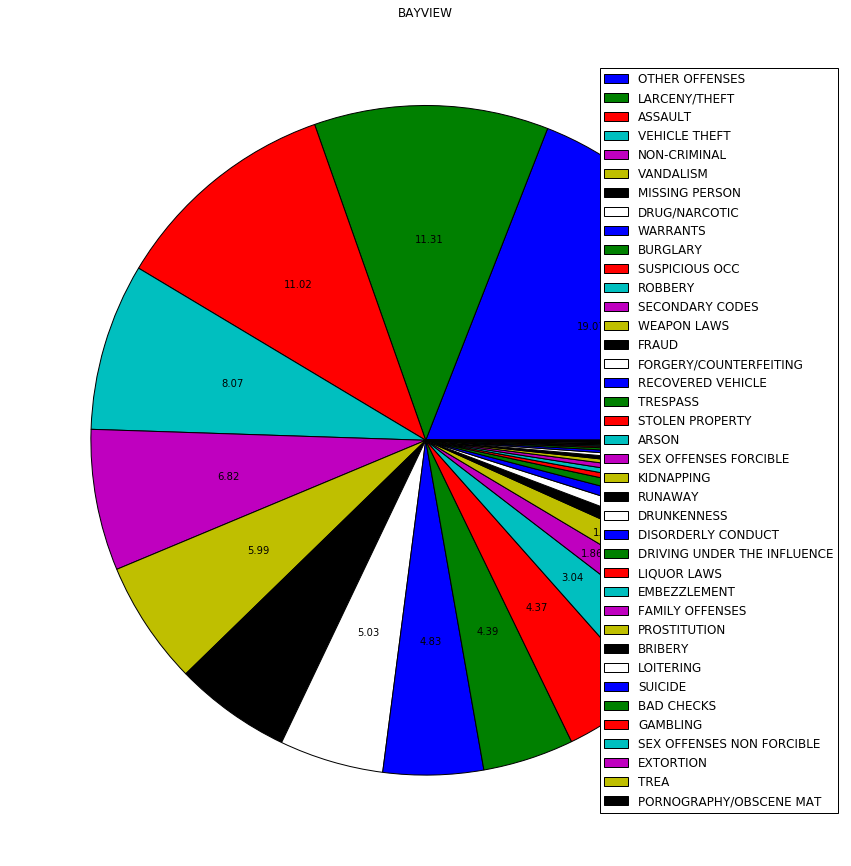

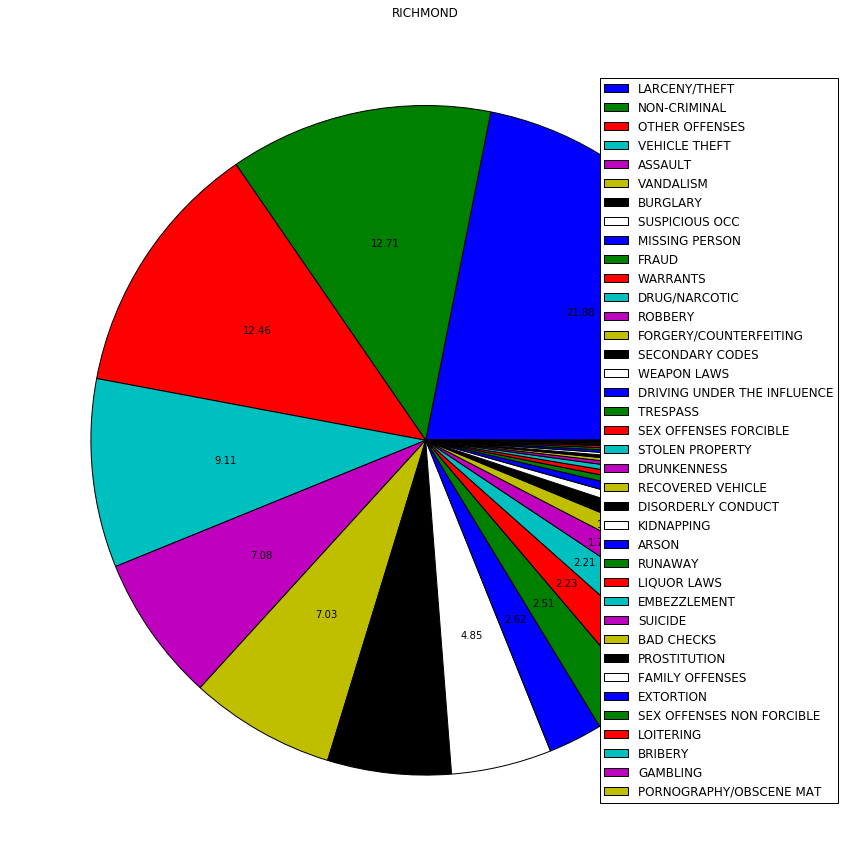

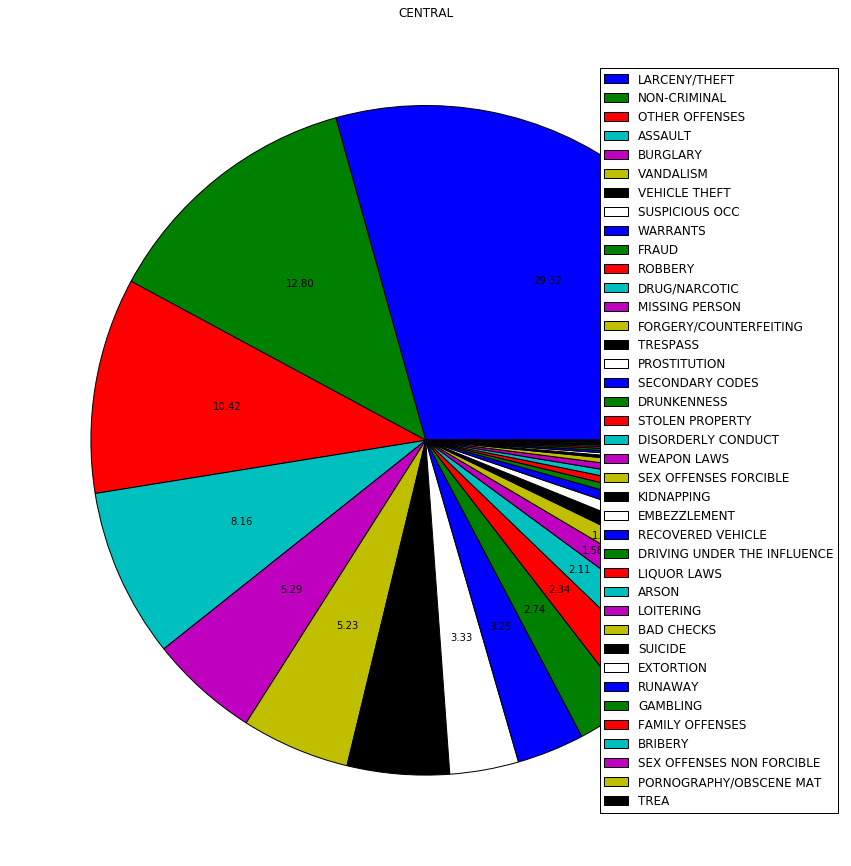

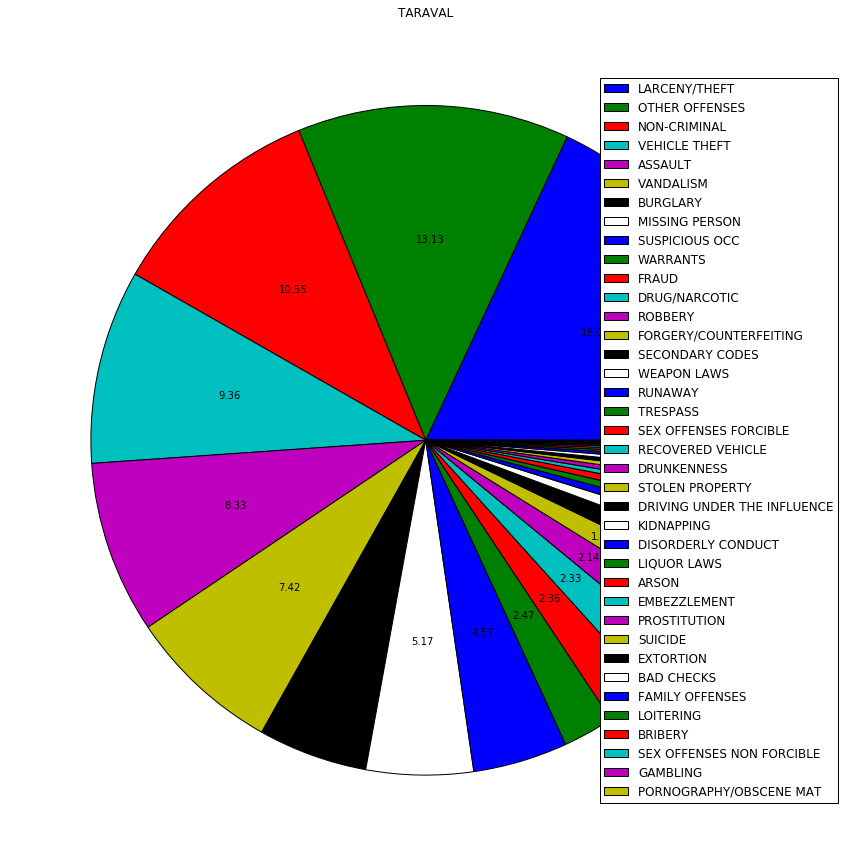

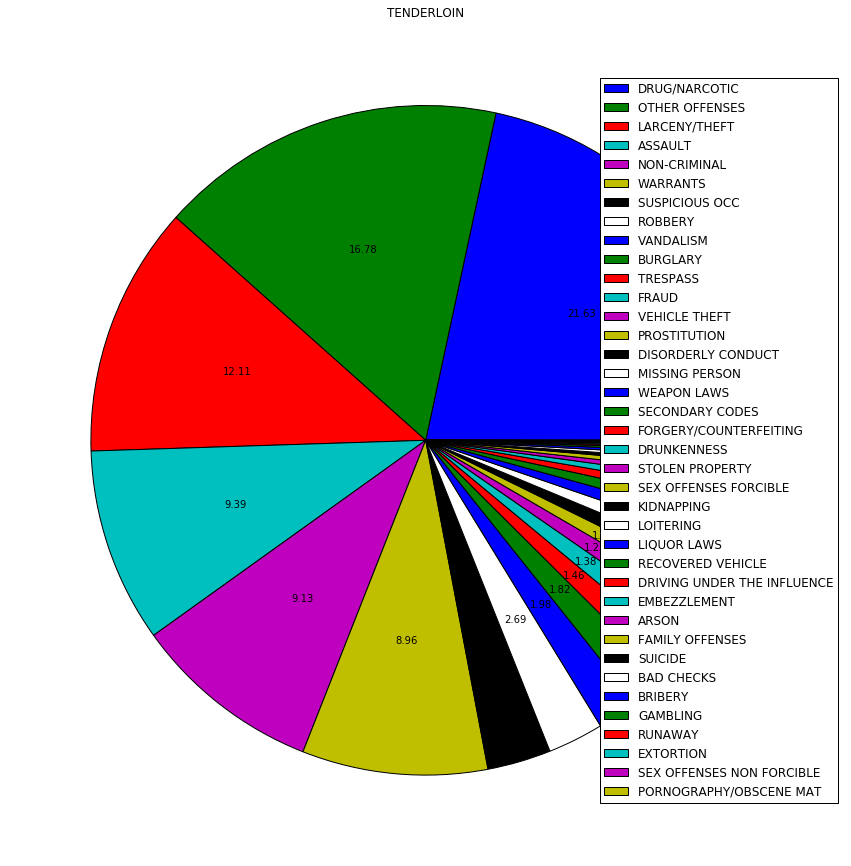

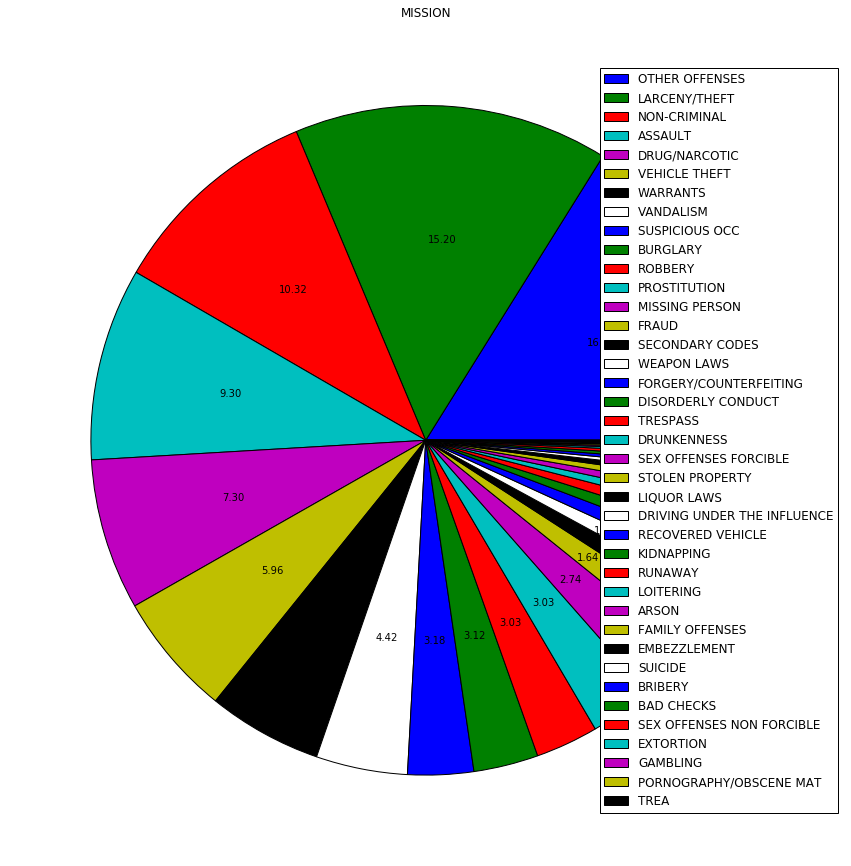

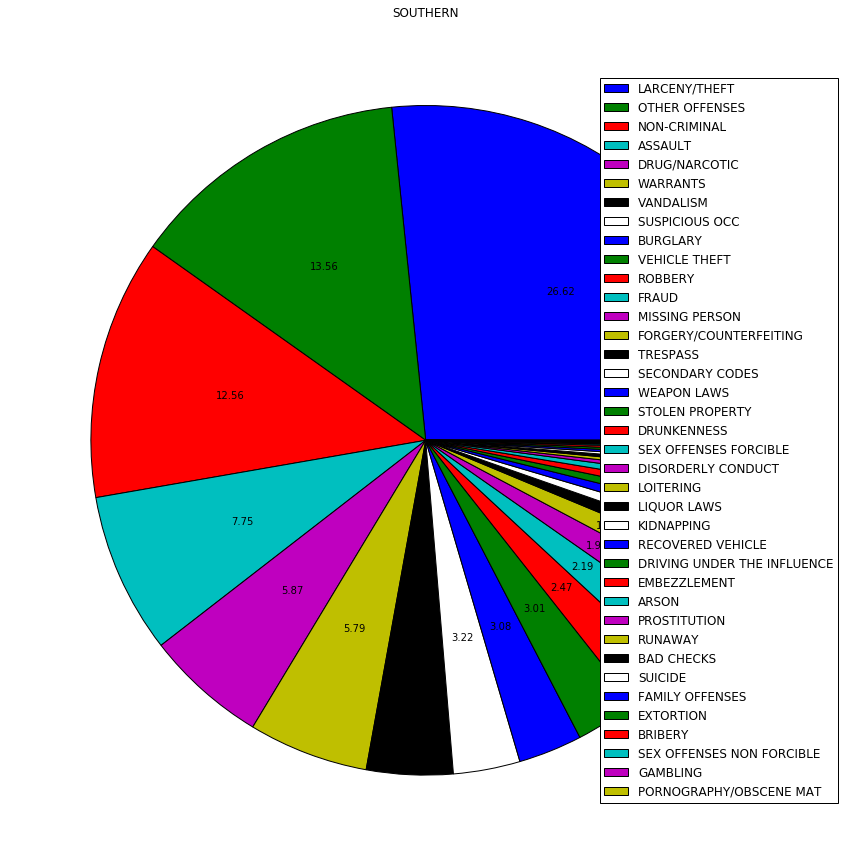

In [8]:
for pdd in train.PdDistrict.unique():
    cats = train.Category[train.PdDistrict == pdd].value_counts()
    plt.figure(figsize=(15,15))
    plt.pie(cats, autopct='%.2f')
    plt.title(pdd)
    plt.legend(cats.index, loc='right')

It looks like the category breakdown can vary quite a bit from district to district.  On a side note, I wish there was a better way to show these pie charts; I can't get the legend out of the way and the categories aren't consistently colored from chart to chart.

In [9]:
# Following code adapted from https://www.kaggle.com/dbennett/sf-crime/test-map

# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
mapdata = np.loadtxt('sf_map_copyright_openstreetmap_contributors.txt')
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

def plotOnMap(df, color='b', fig=None):
    """
    Plot the given data frame on the map
    Unfortunately, the two 'if fig' statements can't be combined
    """
    if not fig:
        fig = plt.figure(figsize=(15,15))
    plt.scatter(df.X, df.Y, color=color)
    for ax in fig.axes:
        ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                  extent=lon_lat_box, 
                  aspect=asp)
    return fig


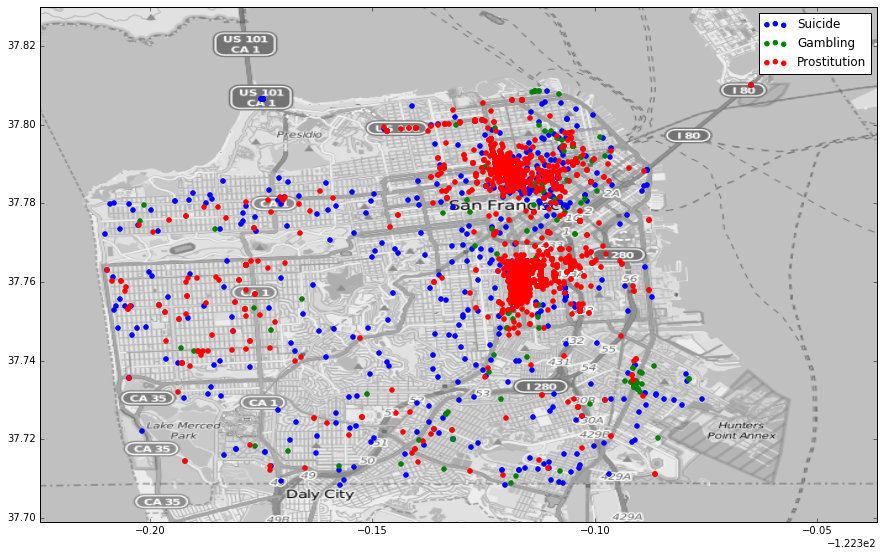

In [10]:
f = plotOnMap(train[train.Category == 'SUICIDE'], 'b')
plotOnMap(train[train.Category == 'GAMBLING'], 'g', f)
plotOnMap(train[train.Category == 'PROSTITUTION'], 'r', f)
plt.legend(['Suicide', 'Gambling', 'Prostitution'])

We can plot data points on a map!  This is a cool way of visualizing the spatial aspects of this dataset.

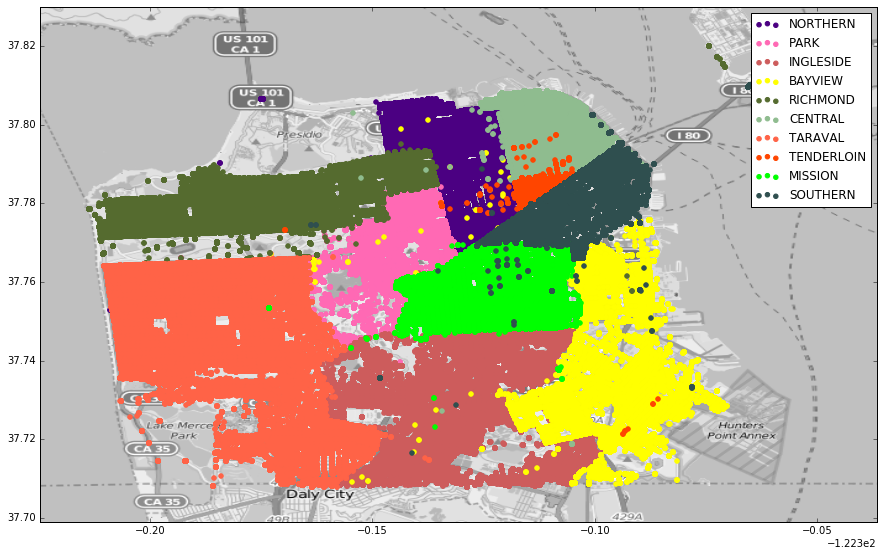

In [11]:
colors = mpl_colors.cnames.keys()[::2]  # skipping every other color gave more distinct colors
pdds = train.PdDistrict.unique()
f = plotOnMap(train[train.PdDistrict == pdds[0]], colors[0])
for i in range(1, len(pdds)):
    plotOnMap(train[train.PdDistrict == pdds[i]], colors[i], f)
plt.legend(pdds)

To give ourselves an idea of where the different PdDistricts are, we can plot the crimes by PdDistrict.  There are some interesting cases of crimes being handled by a PdDistrict far outside of its normal area, but the districts do appear to be pretty segmented overall.

In [12]:
def splitDates(df):
    """
    Split the Dates column of the given data frame into Year, Month, and Day
    """
    df['Year'] = df.Dates.apply(lambda x: int(x.split('-')[0]))
    df['Month'] = df.Dates.apply(lambda x: int(x.split('-')[1]))
    df['Day'] = df.Dates.apply(lambda x: int(x.split(' ')[0].split('-')[2]))

    return df

train = splitDates(train)
test = splitDates(test)

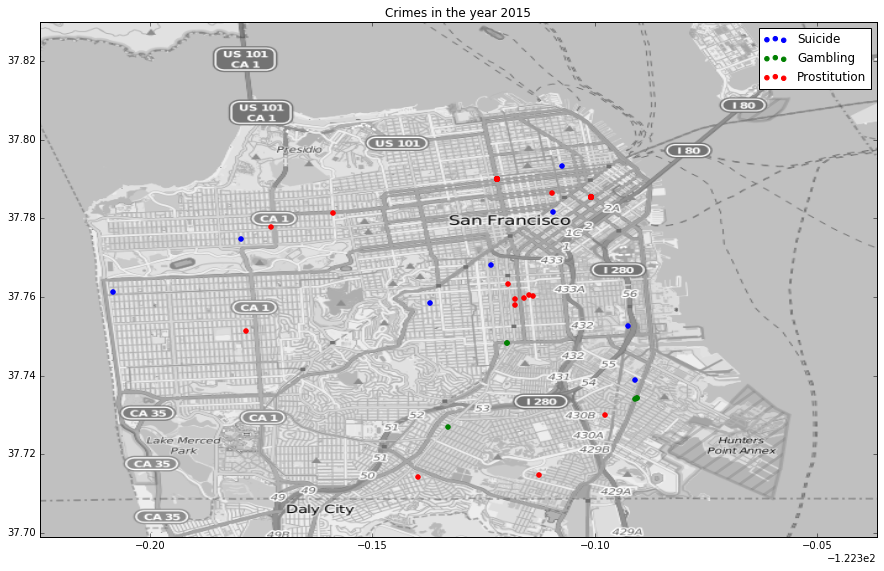

In [13]:
def plotByYear(year):
    """
    Plot crimes from the given year
    Unfortunately, seem to require (ab)using global variables
    """
    df = train[train.Year == year]
    f = plotOnMap(df[df.Category == 'SUICIDE'], 'b')
    plotOnMap(df[df.Category == 'GAMBLING'], 'g', f)
    plotOnMap(df[df.Category == 'PROSTITUTION'], 'r', f)
    plt.legend(['Suicide', 'Gambling', 'Prostitution'])
    plt.title('Crimes in the year {}'.format(year))

year_slider = widgets.IntSlider(min=train.Year.min(), max=train.Year.max(), value=train.Year.min())
widgets.interact(plotByYear, year=year_slider)

Using a slider, we can explore the temporal aspect of the data as well by looking at slices across time.

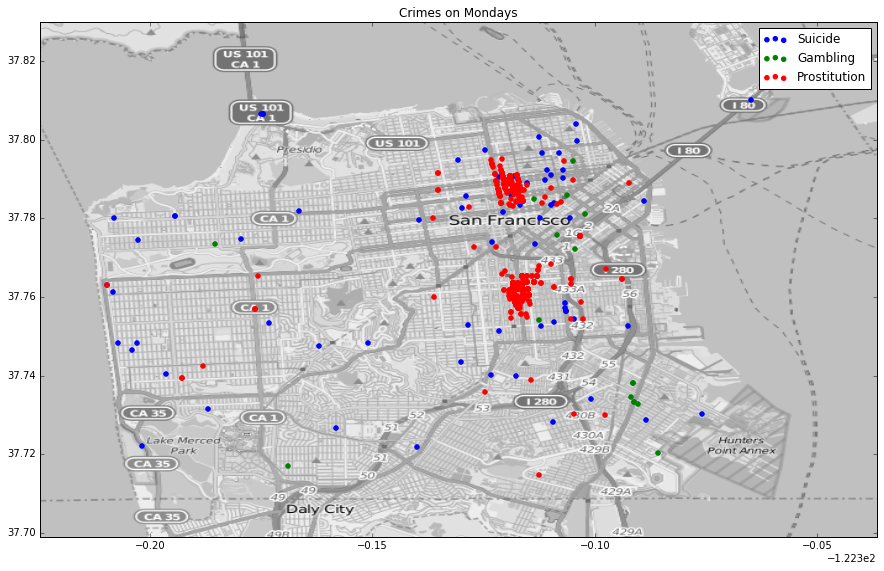

In [14]:
def plotByDayOfWeek(dow):
    """
    Plot crimes from the given day of week
    Unfortunately, seem to require (ab)using global variables
    """
    df = train[train.DayOfWeek == dow]
    f = plotOnMap(df[df.Category == 'SUICIDE'], 'b')
    plotOnMap(df[df.Category == 'GAMBLING'], 'g', f)
    plotOnMap(df[df.Category == 'PROSTITUTION'], 'r', f)
    plt.legend(['Suicide', 'Gambling', 'Prostitution'])
    plt.title('Crimes on {}s'.format(dow))

# I couldn't get the days to be in a reasonable order automatically, so I had
# to enter them manually
dow_dropdown = widgets.Dropdown(description='Day of Week:', options=[
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'
])
widgets.interact(plotByDayOfWeek, dow=dow_dropdown)

We can also look at different days of the week.

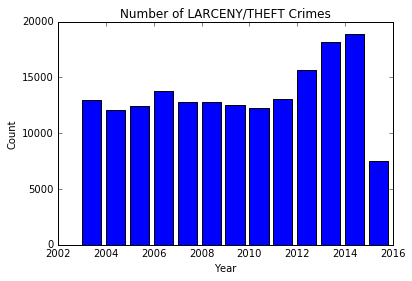

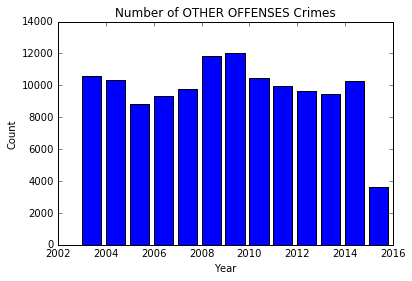

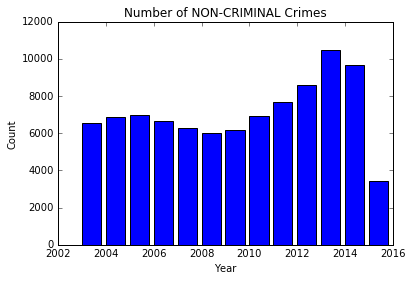

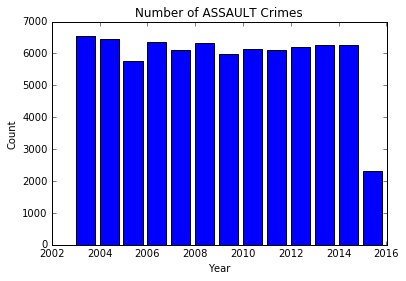

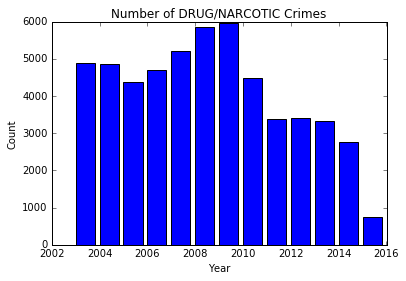

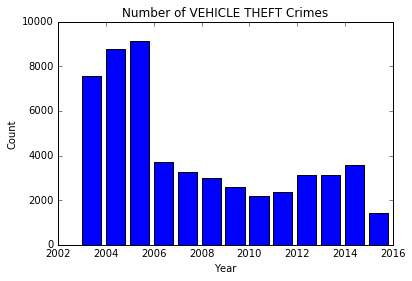

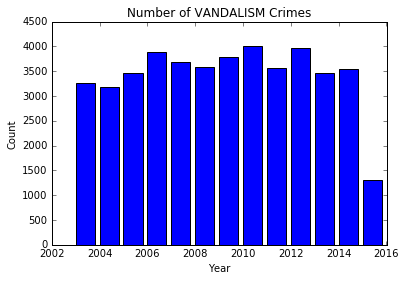

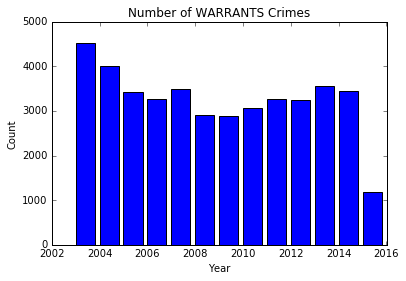

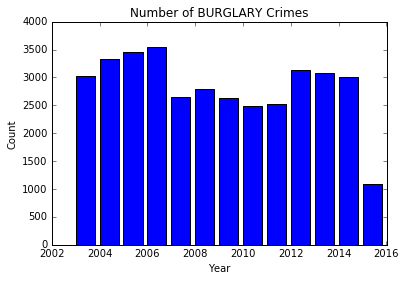

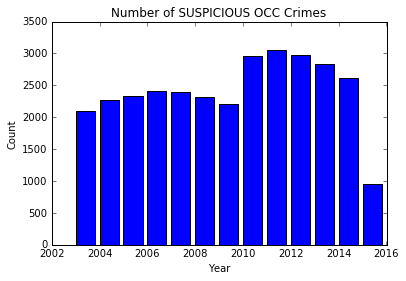

In [16]:
for cat in train.Category.value_counts().index[:10]:
    df = train[train.Category == cat]
    plt.figure()
    plt.title('Number of {} Crimes'.format(cat))
    plt.xlabel('Year')
    plt.ylabel('Count')
    for year in range(df.Year.min(), df.Year.max()+1, 1):
        plt.bar(year, sum(df.Year == year))

It's interesting to see that some types of crime are on the rise (such as larceny/theft and non-criminal) while others have gone down over the years (such as drug/narcotic and vehicle theft) and other have stayed pretty constant (such as assault and vandalism).